# P0: Intro

<center><b>Machine Learning Project</b></center>
<br><center><b>Sharif University of Technology - Fall 2023</b></center>

<div style="text-align:justify">Hopefully, the course has been insightful for you till now. This notebook serves as a template for the project which involves training a sentiment analyzer neural network using the comments of a Persian website and fine-tuning it using the comments of another.<br><br>
The first website is Snappfood which is used by the people in Iran to order different kinds of food. The latter is Digikala, an online store for Iranians where people buy many things including smartphones, groceries, cars, and whatever you consider legal. Both websites provide users with ways to express their opinions about the products.<br><br>
A domain shift may be revealed to some degree when switching from Snappfood comments to the ones extracted from Digikala. This will be one of the challenges you will be faced with. So, beware of it!</div>

# P1: Exploring the Datasets (25 points)

Both of the datasets are added to the notebook. In this part, we want to explore their contents.

In [ ]:
!pip install hazm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Attention, SpatialDropout1D
from sklearn.metrics import accuracy_score
import json
from tensorflow.keras.models import model_from_json

Load both of the datasets

In [7]:
snappdf = pd.read_csv('/kaggle/input/snappfood-persian-sentiment-analysis/Snappfood - Sentiment Analysis.csv', on_bad_lines='skip' , delimiter='\t')
digidf = pd.read_csv('/kaggle/input/digikala-comments-persian-sentiment-analysis/data.csv')

In [8]:
snappdf.head()

,Unnamed: 0,comment,label,label_id
0,NaN,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0
1,NaN,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0.0
2,NaN,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1.0
3,NaN,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0.0
4,NaN,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0.0


In [9]:
digidf.head()

,Text,Score,Suggestion
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1
1,خرید این محصول رو توصیه میکنم,84,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1


In [10]:
snappdf.drop('Unnamed: 0', axis=1, inplace=True)
snappdf.dropna(inplace=True)
digidf.dropna(inplace=True)

Count the number of comments each dataset contains **(P1-1: 5 points)**

In [11]:
print('Number of comments in Snappfood dataset: ', len(snappdf))
print('Number of comments in Digikala dataset: ', len(digidf))

Number of comments in Snappfood dataset:  69480
Number of comments in Digikala dataset:  3261


Represent the distribution of comments in the Snappfood dataset in terms of being negative or positive **(P1-2: 5 points)**

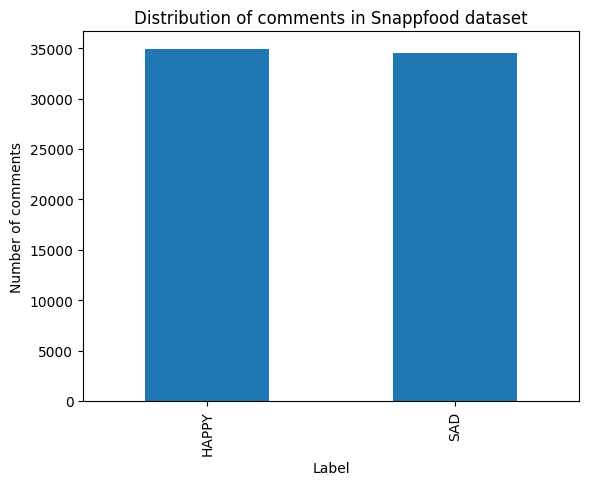

label
HAPPY    34916
SAD      34564
Name: count, dtype: int64


In [12]:
snappdf['label'].value_counts().plot(kind='bar')
plt.title('Distribution of comments in Snappfood dataset')
plt.xlabel('Label')
plt.ylabel('Number of comments')
plt.show()
print(snappdf['label'].value_counts())

Plot the logarithm of the frequency of words as a function of the logarithm of their rank to demonstrate the Zipf's law. <br>
Note: Don't panic! The Zipf's law can be found here: https://nlp.stanford.edu/IR-book/html/htmledition/zipfs-law-modeling-the-distribution-of-terms-1.html and can be easily understood. **(P1-3: 5 points)**

In [14]:
import warnings
warnings.filterwarnings('ignore')

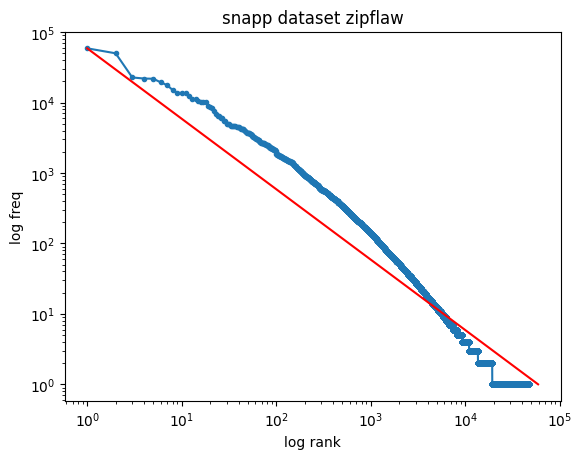

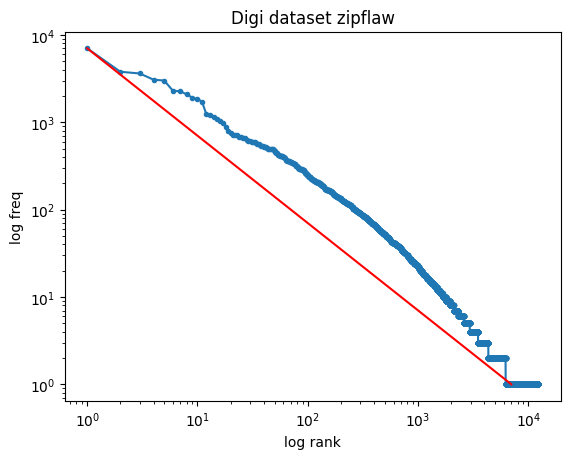

In [15]:
from collections import Counter
import math
import matplotlib.pyplot as plt
import seaborn as sns
def zipf_law(text, title):
    splited = text.str.split(expand=True).stack()
    counts = -splited.value_counts()
    freq = -counts[np.argsort(counts)]
    plt.loglog(np.arange(1, len(counts) + 1), freq, marker=".")
    plt.plot([1,freq[0]],[freq[0],1],color='r')
    plt.xlabel("log rank")
    plt.ylabel("log freq")
    plt.title(title)
    plt.show()
zipf_law(snappdf['comment'],"snapp dataset zipflaw")
zipf_law(digidf['Text'],"Digi dataset zipflaw")

Add a new column to the Digikala dataset indicating whether the comment was positive, negative, or neutral. This will be needed later for classification. <br>
Note: This can be done in many ways. You should the appropriate method. **(P1-4: 5 points)**

In [16]:
def label_digi(x):
  if x['Suggestion'] != 2 and x['Score']>= 70:
    return 'Positive'
  if x['Suggestion'] == 2 or x['Score']<30:
    return 'Negative'
  return 'Neutral'

In [17]:
digidf['label'] = digidf.apply(lambda x: label_digi(x), axis=1)
digidf.head()

,Text,Score,Suggestion,label
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1,Positive
1,خرید این محصول رو توصیه میکنم,84,1,Positive
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1,Neutral
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1,Positive
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1,Positive


In [18]:
digidf['label'].value_counts()

label
Positive    1866
Neutral      845
Negative     550
Name: count, dtype: int64

Split each dataset into training, testing, and validation sets. **(P1-5: 5 points)**

In [19]:
from sklearn.model_selection import train_test_split
digi_train, digi_test = train_test_split(digidf, test_size=0.2, random_state=42)
digi_val, digi_test = train_test_split(digi_test, test_size=0.5, random_state=42)

snapp_train, snapp_test = train_test_split(snappdf, test_size=0.2, random_state=42)
snapp_val, snapp_test = train_test_split(snapp_test, test_size=0.5, random_state=42)

# P2: Preprocessing and Feature Extraction (20 points)

The goal of this part is to make the Snappfood dataset ready for the neural network to be trained with.<br>
Note: You can use many libraries including `NLTK`, `Spacy`, `Hazm`, `Parsivar`, `Stanza` etc.

In [20]:
# let's make the two datasets a little similar
digi_train['comment'] = digi_train['Text']
digi_train.drop(columns=['Score','Suggestion','Text'],inplace=True)
digi_val['comment'] = digi_val['Text']
digi_val.drop(columns=['Score','Suggestion','Text'],inplace=True)
digi_test['comment'] = digi_test['Text']
digi_test.drop(columns=['Score','Suggestion','Text'],inplace=True)

In [21]:
digi_train.head()

,label,comment
997,Positive,واقعا عالی بوی خوبی داره تمیز کنندگی چشم گ...
2952,Positive,من از این مته ها استفاده کردم براى سنگ دیوار ح...
3117,Positive,این همزن را هفته پیش گرفتم ساخت اسلوونى است و...
1451,Neutral,عالیه این بهترین چیزی بوده که تا به حال از ای...
2849,Positive,کیفیت خیلی خوب


Remove the unnecessary characters of the dataset. <br>
**(P2-1: 5 points)**

In [22]:
all_comments = ' '.join(snapp_train['comment'].astype(str))
unique_characters = set(all_comments) # just wanted to see what we have here
print(unique_characters)

{'v', '؛', 't', 'g', 'w', '∆', 'S', 'P', '٬', 'O', '٫', '٣', 'q', ',', '۰', '۶', 'غ', 'ذ', '٩', 'ج', 'z', '١', 'V', 'N', '-', '.', 'ع', '\u200c', '۷', 'و', 'K', 'ط', '\u202a', 'X', 'ڇ', 'd', 'ک', '۹', 'p', 'ژ', 'r', ')', '٧', 'خ', '٦', '"', 'ٔ', 'x', '>', '/', '٨', '^', 'ە', '۴', '\u200f', 'ص', '(', 'B', 'c', ';', 'R', 'ء', 'ہ', 'ۀ', '؟', 'ض', 'k', '`', 'ن', ' ', 'F', '’', 'Y', '=', '…', 'l', 'إ', 'I', '٪', 'A', 'ت', 'j', 'C', ':', 'ث', 'ق', 'س', '۳', 'U', '\u200e', 'G', '@', 'ب', '،', 'ش', 'ة', 'ؤ', 'W', 'J', '\u061c', 'a', '۱', '\u202c', '٥', 'ى', 'ر', 'T', 'H', '[', '+', 's', 'م', 'ح', 'M', '٤', '۲', 'D', 'u', '۵', 'ز', 'Z', 'أ', 'n', 'o', 'L', 'ھ', "'", 'y', 'گ', '٢', 'پ', '٠', '&', '!', '۸', 'چ', 'ئ', '<', '۔', 'ف', 'آ', '?', 'h', 'ل', 'ظ', 'f', 'ی', 'b', 'E', 'د', 'e', 'i', 'ه', 'ا', 'm', '\\'}


In [23]:
import re
def keep_persian_english(text):
    cleaned_text = re.sub(r'[^a-zA-Zا-ی\s]', '', text)
    return cleaned_text

for df in [snapp_train, snapp_val, snapp_test]:
    df['cleaned_comment'] = df['comment'].apply(keep_persian_english)

for df in [digi_train, digi_val, digi_test]:
    df['cleaned_comment'] = df['comment'].apply(keep_persian_english)

Normalize the dataset. <br>
Note: Check the result. For instance, if you do this correctly, you'll have a dataset containing just 1 type of space. **(P2-2: 5 points)**

If you want to include other preprocessing steps, put all of your code here.

In [25]:
from hazm import Normalizer, word_tokenize, Stemmer
normalizer = Normalizer()
tokenizer = word_tokenize
stemmer = Stemmer()
def nts(df):
    df['normalized_comment'] = df['cleaned_comment'].apply(lambda x: normalizer.normalize(x))
    df['tokenized_comment'] = df['normalized_comment'].apply(lambda x: tokenizer(x))
    df['text'] = df['tokenized_comment'].apply(lambda x: [stemmer.stem(word) for word in x])

for df in [snapp_train, snapp_val, snapp_test]:
    nts(df)
for df in [digi_train, digi_val, digi_test]:
    nts(df)

In [26]:
snapp_train.head()

,comment,label,label_id,cleaned_comment,normalized_comment,tokenized_comment,text
44754,همیشه این ساندویچ رو میگرفتم عالی بود ولی اینب...,SAD,1.0,همیشه این ساندویچ رو میگرفتم عالی بود ولی اینب...,همیشه این ساندویچ رو می‌گرفتم عالی بود ولی این...,"[همیشه, این, ساندویچ, رو, می‌گرفتم, عالی, بود,...","[همیشه, این, ساندویچ, رو, می‌گرف, عال, بود, ول..."
33432,غذاى سرد در حدى که طعمش اصلا به چشم نیومد، متا...,SAD,1.0,غذاى سرد در حدى که طعمش اصلا به چشم نیومد متاس...,غذای سرد در حدی که طعمش اصلا به چشم نیومد متاس...,"[غذای, سرد, در, حدی, که, طعمش, اصلا, به, چشم, ...","[غذا, سرد, در, حد, که, طعم, اصلا, به, چ, نیومد..."
11332,کیک‌ها متاسفانه کهنه و قدیمی بود. همچنین به عل...,SAD,1.0,کیکها متاسفانه کهنه و قدیمی بود همچنین به علت ...,کیکها متاسفانه کهنه و قدیمی بود همچنین به علت ...,"[کیکها, متاسفانه, کهنه, و, قدیمی, بود, همچنین,...","[کیک, متاسفانه, کهنه, و, قدیم, بود, همچنین, به..."
52624,از همه نظر راضی بودم. ممنونم,HAPPY,0.0,از همه نظر راضی بودم ممنونم,از همه نظر راضی بودم ممنونم,"[از, همه, نظر, راضی, بودم, ممنونم]","[از, همه, نظر, راض, بود, ممنون]"
48963,به علت اشتباه پیک بابت تحویل غذا غذا یخ بود,SAD,1.0,به علت اشتباه پیک بابت تحویل غذا غذا یخ بود,به علت اشتباه پیک بابت تحویل غذا غذا یخ بود,"[به, علت, اشتباه, پیک, بابت, تحویل, غذا, غذا, ...","[به, عل, اشتباه, پیک, باب, تحویل, غذا, غذا, یخ..."


In [27]:
digi_train.head()

,label,comment,cleaned_comment,normalized_comment,tokenized_comment,text
997,Positive,واقعا عالی بوی خوبی داره تمیز کنندگی چشم گ...,واقعا عالی بوی خوبی داره تمیز کنندگی چشم گ...,واقعا عالی بوی خوبی داره تمیز کنندگی چشم گیری ...,"[واقعا, عالی, بوی, خوبی, داره, تمیز, کنندگی, چ...","[واقعا, عال, بو, خوب, داره, تمیز, کنندگ, چ, گی..."
2952,Positive,من از این مته ها استفاده کردم براى سنگ دیوار ح...,من از این مته ها استفاده کردم براى سنگ دیوار ح...,من از این مته‌ها استفاده کردم برای سنگ دیوار ح...,"[من, از, این, مته‌ها, استفاده, کردم, برای, سنگ...","[من, از, این, مته, استفاده, کرد, برا, سنگ, دیو..."
3117,Positive,این همزن را هفته پیش گرفتم ساخت اسلوونى است و...,این همزن را هفته پیش گرفتم ساخت اسلوونى است و...,این همزن را هفته پیش گرفتم ساخت اسلوونی است و ...,"[این, همزن, را, هفته, پیش, گرفتم, ساخت, اسلوون...","[این, همزن, را, هفته, پ, گرف, ساخ, اسلوون, اس,..."
1451,Neutral,عالیه این بهترین چیزی بوده که تا به حال از ای...,عالیه این بهترین چیزی بوده که تا به حال از ای...,عالیه این بهترین چیزی بوده که تا به حال از این...,"[عالیه, این, بهترین, چیزی, بوده, که, تا, به, ح...","[عالیه, این, به, چیز, بوده, که, تا, به, حال, ا..."
2849,Positive,کیفیت خیلی خوب,کیفیت خیلی خوب,کیفیت خیلی خوب,"[کیفیت, خیلی, خوب]","[کیف, خیل, خوب]"


In [28]:
for df in [snapp_train, snapp_val, snapp_test]:
    df.drop(['normalized_comment', 'tokenized_comment', 'cleaned_comment', 'label', 'comment'], axis=1, inplace=True)
for df in [digi_train, digi_val, digi_test]:
    df.drop(['normalized_comment', 'tokenized_comment', 'cleaned_comment'], axis=1, inplace=True)

In [29]:
for df in [snapp_train, snapp_val, snapp_test]:
    df.rename(columns={'label_id': 'label'}, inplace=True)

In [30]:
digi_train.head()

,label,comment,text
997,Positive,واقعا عالی بوی خوبی داره تمیز کنندگی چشم گ...,"[واقعا, عال, بو, خوب, داره, تمیز, کنندگ, چ, گی..."
2952,Positive,من از این مته ها استفاده کردم براى سنگ دیوار ح...,"[من, از, این, مته, استفاده, کرد, برا, سنگ, دیو..."
3117,Positive,این همزن را هفته پیش گرفتم ساخت اسلوونى است و...,"[این, همزن, را, هفته, پ, گرف, ساخ, اسلوون, اس,..."
1451,Neutral,عالیه این بهترین چیزی بوده که تا به حال از ای...,"[عالیه, این, به, چیز, بوده, که, تا, به, حال, ا..."
2849,Positive,کیفیت خیلی خوب,"[کیف, خیل, خوب]"


In [31]:
from hazm import Lemmatizer
lemmatizer = Lemmatizer()
def lemmatize_text(df):
    df['text'] = df['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
for df in [snapp_train, snapp_val, snapp_test]:
    lemmatize_text(df)

for df in [digi_train, digi_val, digi_test]:
    lemmatize_text(df)

In [32]:
from hazm import stopwords_list
stopwords_set = set(stopwords_list())
def remove_stopwords(df):
    df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stopwords_set])

for df in [snapp_train, snapp_val, snapp_test]:
    remove_stopwords(df)
for df in [digi_train, digi_val, digi_test]:
    remove_stopwords(df)

In [33]:
def join_words(df):
    df['text'] = df['text'].apply(lambda x: ' '.join(x))
for df in [snapp_train, snapp_val, snapp_test]:
    join_words(df)
for df in [digi_train, digi_val, digi_test]:
    join_words(df)

Extract features from the Snappfood dataset
<br> Note: You should use both of the following methods, and compare the results at the end.
- Method 1 (Classic): Use `CountVectorizer` or `TF-IDF`.
- Method 2 (Modern): Use `Word2Vec`, `FastText`, `GloVe`, `Doc2Vec` or train your own `Embedding` Layer.

If you choose to train your own `Embedding`s, you'll just need to specify an ID for each word remaining in your dataset. **(P2-3: 10 points)**

In [53]:
def w2v(x,model):
    vectors = [model.wv[word] for word in x.split() if word in model.wv]
    if len(vectors) == 0:return np.zeros(100)
    return np.array(vectors).mean(axis=0)

# Method 1:

In [36]:
vectorizer = CountVectorizer(max_features=300)
scv_X_train = vectorizer.fit_transform(snapp_train['text'])
scv_X_val = vectorizer.transform(snapp_val['text'])
scv_X_test = vectorizer.transform(snapp_test['text'])

scv_y_train = snapp_train['label']
scv_y_val = snapp_val['label']
scv_y_test = snapp_test['label']

# P3: Training and Initial Evaluation (20 points)

Define an architecture for your neural network. **(P3-1: 5 points)**

In [37]:
model = Sequential()
model.add(Embedding(input_dim=scv_X_train.shape[1], output_dim=64, input_length=scv_X_train.shape[1]))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           19200     
                                                                 
 bidirectional (Bidirection  (None, 300, 64)           24832     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 300, 64)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 300, 64)           24832     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 300, 64)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                2

Train the network on the Snappfood dataset, while monitoring its performance on the validation set. **(P3-2: 5 points)**

In [38]:
epochs = 5
batch_size = 32
history = model.fit(scv_X_train.toarray(), scv_y_train, epochs=5, batch_size=32,validation_data=(scv_X_val.toarray(),scv_y_val))

Epoch 1/5
1737/1737 [==============================] - 96s 50ms/step - loss: 0.6700 - accuracy: 0.5771 - val_loss: 0.6484 - val_accuracy: 0.6153
Epoch 2/5
1737/1737 [==============================] - 83s 48ms/step - loss: 0.6428 - accuracy: 0.6308 - val_loss: 0.6365 - val_accuracy: 0.6455
Epoch 3/5
1737/1737 [==============================] - 82s 47ms/step - loss: 0.6319 - accuracy: 0.6478 - val_loss: 0.6218 - val_accuracy: 0.6644
Epoch 4/5
1737/1737 [==============================] - 82s 47ms/step - loss: 0.6266 - accuracy: 0.6539 - val_loss: 0.6176 - val_accuracy: 0.6744
Epoch 5/5
1737/1737 [==============================] - 82s 47ms/step - loss: 0.6232 - accuracy: 0.6569 - val_loss: 0.6262 - val_accuracy: 0.6606


Evaluate the performance of your network on the Snappfood testing set. **(P3-3: 5 points)**

In [39]:
test_loss, test_accuracy = model.evaluate(scv_X_test.toarray(), scv_y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

218/218 [==============================] - 5s 21ms/step - loss: 0.6153 - accuracy: 0.6596
Test Loss: 0.6153, Test Accuracy: 0.6596


Save the weights of the neural network and its architecture seperately in the notebook's output folder (`/kaggle/working/`). **(P3-4: 5 points)**

In [41]:
model_json = model.to_json()
with open('/kaggle/working/scv_architecture.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('/kaggle/working/scv_weights.h5')

# P4: Fine-tuning and Evaluation (35 points)

In this part, we will fine-tune the previously trained network on the comments extracted from Digikala.

Load the neural network along with its weights **(P4-1: 5 points)**

In [42]:
with open('/kaggle/working/scv_architecture.json', 'r') as json_file:
    scv_model_json = json_file.read()

scv_model = model_from_json(scv_model_json)
scv_model.load_weights('/kaggle/working/scv_weights.h5')

Change the architecture of the network (the last layer) to make it appropriate for classifying the sentiment of a comment in one of the previously mentioned three classes: positive, negative, or neutral. **(P4-2: 5 points)**

In [43]:
scv_model.layers.pop()
newFC = Dense(3, activation='softmax')(scv_model.layers[-1].output)
scv_model_fine = Model(inputs=scv_model.input, outputs=newFC)
scv_model_fine.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
scv_model_fine.trainable = True

Extract features from the Digikala dataset.<br>
Note: Pay attention to the fact that your features are the same as the ones you extracted from the Snappfood dataset. You just need to use the same method for the new dataset. For instance, if you consider the `CountVectorizer` as your feature extractor, the set of the words for which you'll count the frequency will not change! **(P4-3: 15 points)**

In [44]:
dcv_X_train = vectorizer.transform(digi_train['text'])
dcv_X_val = vectorizer.transform(digi_val['text'])
dcv_X_test = vectorizer.transform(digi_test['text'])
dcv_y_train = pd.get_dummies(digi_train['label']).values
dcv_y_val = pd.get_dummies(digi_val['label']).values
dcv_y_test = pd.get_dummies(digi_test['label']).values

Fine-tune the network on the training set associated with the Digikala dataset, while monitoring its performance on the corresponding validation set.<br>
Note: The process of fine-tuning should follow one of these methods:
- Method 1: Fix the weights for all layers expect the last one.
- Method 2: Use a really small learning rate for all layers except the last one.

**(P4-4: 5 points)**

In [45]:
for layer in scv_model_fine.layers[:-1]:
    layer.trainable = False
scv_model_fine.layers[-1].trainable = True
epochs = 5
batch_size = 32
history1d = scv_model_fine.fit(dcv_X_train.toarray(), dcv_y_train, epochs=epochs, batch_size=batch_size,validation_data=(dcv_X_val.toarray(),dcv_y_val))

Epoch 1/5
82/82 [==============================] - 18s 101ms/step - loss: 1.1419 - accuracy: 0.3462 - val_loss: 1.0712 - val_accuracy: 0.5890
Epoch 2/5
82/82 [==============================] - 4s 53ms/step - loss: 1.0577 - accuracy: 0.5729 - val_loss: 1.0393 - val_accuracy: 0.5951
Epoch 3/5
82/82 [==============================] - 4s 50ms/step - loss: 1.0346 - accuracy: 0.5736 - val_loss: 1.0172 - val_accuracy: 0.5951
Epoch 4/5
82/82 [==============================] - 4s 53ms/step - loss: 1.0172 - accuracy: 0.5736 - val_loss: 1.0001 - val_accuracy: 0.5951
Epoch 5/5
82/82 [==============================] - 4s 51ms/step - loss: 1.0036 - accuracy: 0.5736 - val_loss: 0.9868 - val_accuracy: 0.5951


Evaluate the performance of the neural network on the testing set you have extracted from the Digikala dataset. **(P4-5: 5 points)**

In [52]:
digi_test_pred = scv_model_fine.predict(dcv_X_test.toarray())
print(accuracy_score(np.argmax(dcv_y_test, axis=1), np.argmax(digi_test_pred, axis=1)))

11/11 [==============================] - 0s 31ms/step
0.5382262996941896


# Method 2

In [55]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in snapp_train['text']]
w2v_model = Word2Vec(sentences, window=10, min_count=5, workers=4)
swv_X_train = np.array([w2v(x,w2v_model) for x in snapp_train['text']])
swv_X_val = np.array([w2v(x,w2v_model) for x in snapp_val['text']])
swv_X_test = np.array([w2v(x,w2v_model) for x in snapp_test['text']])

# P3: Training and Initial Evaluation (20 points) [Method 2]

Define an architecture for your neural network. **(P3-1: 5 points)**

In [56]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(w2v_model.vector_size, 1)))
model2.add(Bidirectional(LSTM(32, return_sequences=True)))
model2.add(Dropout(0.5))
model2.add(Bidirectional(LSTM(32, return_sequences=True)))
model2.add(Dropout(0.5))
model2.add(Bidirectional(LSTM(32)))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100, 64)           128       
                                                                 
 bidirectional_3 (Bidirecti  (None, 100, 64)           24832     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 100, 64)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 100, 64)           24832     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 100, 64)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)               

Train the network on the Snappfood dataset, while monitoring its performance on the validation set. **(P3-2: 5 points)**

In [57]:
epochs = 5
batch_size = 32
history = model2.fit(swv_X_train, snapp_train['label'], epochs=epochs, batch_size=batch_size,validation_data=(swv_X_val, snapp_val['label']))

Epoch 1/5
1737/1737 [==============================] - 50s 24ms/step - loss: 0.4943 - accuracy: 0.7581 - val_loss: 0.4652 - val_accuracy: 0.7788
Epoch 2/5
1737/1737 [==============================] - 38s 22ms/step - loss: 0.4692 - accuracy: 0.7753 - val_loss: 0.4484 - val_accuracy: 0.7903
Epoch 3/5
1737/1737 [==============================] - 39s 22ms/step - loss: 0.4537 - accuracy: 0.7850 - val_loss: 0.4391 - val_accuracy: 0.7930
Epoch 4/5
1737/1737 [==============================] - 39s 22ms/step - loss: 0.4457 - accuracy: 0.7890 - val_loss: 0.4480 - val_accuracy: 0.7868
Epoch 5/5
1737/1737 [==============================] - 39s 22ms/step - loss: 0.4408 - accuracy: 0.7919 - val_loss: 0.4319 - val_accuracy: 0.8024


Evaluate the performance of your network on the Snappfood testing set. **(P3-3: 5 points)**

In [60]:
from sklearn.metrics import confusion_matrix

In [63]:
test_loss, test_accuracy = model2.evaluate(swv_X_test, snapp_test['label'])
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
swv_y_pred = np.round(model2.predict(swv_X_test))
print(f"Accuracy {accuracy_score(snapp_test['label'], swv_y_pred)}")
print(f"F1_score {f1_score(snapp_test['label'], swv_y_pred)}")
print(f"confusion matrix {confusion_matrix(snapp_test['label'], swv_y_pred)}")

218/218 [==============================] - 2s 10ms/step - loss: 0.4366 - accuracy: 0.7958
Test Loss: 0.4366, Test Accuracy: 0.7958
218/218 [==============================] - 4s 9ms/step
Accuracy 0.7957685664939551
F1_score 0.8085795224605423
confusion matrix [[2532  898]
 [ 521 2997]]


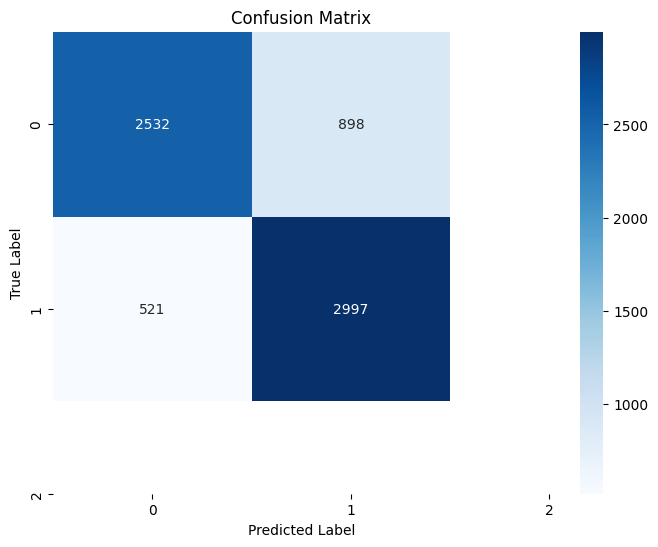

In [64]:
conf_matrix = confusion_matrix(snapp_test['label'], swv_y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Save the weights of the neural network and its architecture seperately in the notebook's output folder (`/kaggle/working/`). **(P3-4: 5 points)**

In [66]:
model2_json = model2.to_json()
with open('/kaggle/working/swv_architecture.json', 'w') as json_file:
    json_file.write(model2_json)

model2.save_weights('/kaggle/working/swv_weights.h5')

# P4: Fine-tuning and Evaluation (35 points) [Method 2]

In this part, we will fine-tune the previously trained network on the comments extracted from Digikala.

Load the neural network along with its weights **(P4-1: 5 points)**

In [99]:
with open('/kaggle/working/swv_architecture.json', 'r') as json_file:
    swv_model_json = json_file.read()

swv_model = model_from_json(swv_model_json)
swv_model.load_weights('/kaggle/working/swv_weights.h5')

Change the architecture of the network (the last layer) to make it appropriate for classifying the sentiment of a comment in one of the previously mentioned three classes: positive, negative, or neutral. **(P4-2: 5 points)**

In [100]:
swv_model.layers.pop()
newFC1 = Dense(64, activation='relu')(swv_model.layers[-1].output)
newFC2 = Dense(32, activation='relu')(newFC1)
newFC3 = Dense(3, activation='softmax')(newFC2)
swv_model_fine = Model(inputs=swv_model.input, outputs=newFC3)
swv_model_fine.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
swv_model_fine.trainable = True

Extract features from the Digikala dataset.<br>
Note: Pay attention to the fact that your features are the same as the ones you extracted from the Snappfood dataset. You just need to use the same method for the new dataset. For instance, if you consider the `CountVectorizer` as your feature extractor, the set of the words for which you'll count the frequency will not change! **(P4-3: 15 points)**

In [101]:
dwv_X_train = np.array([w2v(x,w2v_model) for x in digi_train['text']])
dwv_X_val = np.array([w2v(x,w2v_model) for x in digi_val['text']])
dwv_X_test = np.array([w2v(x,w2v_model) for x in digi_test['text']])

Fine-tune the network on the training set associated with the Digikala dataset, while monitoring its performance on the corresponding validation set.<br>
Note: The process of fine-tuning should follow one of these methods:
- Method 1: Fix the weights for all layers expect the last one.
- Method 2: Use a really small learning rate for all layers except the last one.

**(P4-4: 5 points)**

In [102]:
for layer in swv_model_fine.layers[:-3]:
    layer.trainable = False
swv_model_fine.layers[-3].trainable = True
swv_model_fine.layers[-2].trainable = True
swv_model_fine.layers[-1].trainable = True
epochs = 5
batch_size = 32
history1d = swv_model_fine.fit(dwv_X_train, dcv_y_train, epochs=epochs, batch_size=batch_size,validation_data=(dwv_X_val,dcv_y_val))

Epoch 1/5
82/82 [==============================] - 16s 51ms/step - loss: 0.9959 - accuracy: 0.5683 - val_loss: 0.9480 - val_accuracy: 0.5951
Epoch 2/5
82/82 [==============================] - 2s 24ms/step - loss: 0.9673 - accuracy: 0.5736 - val_loss: 0.9429 - val_accuracy: 0.5951
Epoch 3/5
82/82 [==============================] - 2s 24ms/step - loss: 0.9630 - accuracy: 0.5736 - val_loss: 0.9485 - val_accuracy: 0.5951
Epoch 4/5
82/82 [==============================] - 2s 24ms/step - loss: 0.9598 - accuracy: 0.5736 - val_loss: 0.9520 - val_accuracy: 0.5951
Epoch 5/5
82/82 [==============================] - 2s 24ms/step - loss: 0.9617 - accuracy: 0.5736 - val_loss: 0.9443 - val_accuracy: 0.5951


Evaluate the performance of the neural network on the testing set you have extracted from the Digikala dataset. **(P4-5: 5 points)**

In [105]:
digi_test_pred = swv_model_fine.predict(dwv_X_test)
print(accuracy_score(np.argmax(dcv_y_test, axis=1), np.argmax(digi_test_pred, axis=1)))

11/11 [==============================] - 2s 14ms/step
0.5382262996941896


# Something Something
I tried using LSTM + Attention and the result became way better but sadly my custom attention was not serializable so I could not load it. Therefore, I used the bilstm which had a fair performance. Still way better than random